# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.


In [127]:
! pip install pandas-ta

In [128]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
# in /usr/local/lib/python3.11/dist-packages/pandas_ta/momentum/squeeze_pro.py
# change
# from numpy import NaN as npNaN
# to
# import numpy as np
# npNaN = np.nan
import warnings
warnings.filterwarnings('ignore')

In [129]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [130]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
len(symbols_list)
# Note this is without the survivorship bias

503

In [131]:
end_date = '2025-05-01'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
start_date

Timestamp('2017-05-03 00:00:00')

In [132]:
df_int = (
    yf.download(
        tickers=symbols_list,
        start=start_date,
        end=end_date,
        auto_adjust=False,   # <-- get raw prices + “Adj Close”
    ).stack())


[*********************100%***********************]  503 of 503 completed


In [133]:
df_int

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2017-05-03 A        52.861504   56.160000   56.259998   55.610001   55.680000   
           AAPL     34.113815   36.764999   36.872501   36.067501   36.397499   
           ABBV     47.400528   66.739998   66.879997   66.209999   66.449997   
           ABT      37.930347   43.720001   43.750000   43.490002   43.610001   
           ACGL     30.625275   32.206669   32.296665   32.023335   32.053333   
...                       ...         ...         ...         ...         ...   
2025-04-30 XYL     120.186172  120.570000  120.790001  117.040001  118.059998   
           YUM     149.705643  150.440002  151.559998  144.889999  147.490005   
           ZBH     103.050003  103.050003  103.199997  101.250000  102.730003   
           ZBRA    250.320007  250.320007  251.289993  243.529999  246.179993   
           ZTS     156.399994  156.399994  157.199997  153.770004  155.720001   

Price                   Volume  
Date       Ticker               
2017-05-03 A         1702600.0  
           AAPL    182788000.0  
           ABBV      4993400.0  
           ABT       4579700.0  
           ACGL       903300.0  
...                        ...  
2025-04-30 XYL       2701500.0  
           YUM       3349500.0  
           ZBH       1399600.0  
           ZBRA       762600.0  
           ZTS       2926200.0  

[990166 rows x 6 columns]

In [134]:
df = df_int

In [135]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-03 A        52.861504   56.160000   56.259998   55.610001   55.680000   
           AAPL     34.113815   36.764999   36.872501   36.067501   36.397499   
           ABBV     47.400528   66.739998   66.879997   66.209999   66.449997   
           ABT      37.930347   43.720001   43.750000   43.490002   43.610001   
           ACGL     30.625275   32.206669   32.296665   32.023335   32.053333   
...                       ...         ...         ...         ...         ...   
2025-04-30 XYL     120.186172  120.570000  120.790001  117.040001  118.059998   
           YUM     149.705643  150.440002  151.559998  144.889999  147.490005   
           ZBH     103.050003  103.050003  103.199997  101.250000  102.730003   
           ZBRA    250.320007  250.320007  251.289993  243.529999  246.179993   
           ZTS     156.399994  156.399994  157.199997  153.770004  155.720001   

Price                   volume  
date       ticker               
2017-05-03 A         1702600.0  
           AAPL    182788000.0  
           ABBV      4993400.0  
           ABT       4579700.0  
           ACGL       903300.0  
...                        ...  
2025-04-30 XYL       2701500.0  
           YUM       3349500.0  
           ZBH       1399600.0  
           ZBRA       762600.0  
           ZTS       2926200.0  

[990166 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [136]:
df['garman_klass_vol'] = (np.log(df['high'])-np.log(df['low']))**2/2 - (2*np.log(2)-1)*(np.log(df['adj close'])-np.log(df['open']))**2

In [137]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x:pandas_ta.rsi(close=x, length=20)) # Note RSI isnt Normalized

In [138]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


In [139]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-03 A        52.861504   56.160000   56.259998   55.610001   55.680000   
           AAPL     34.113815   36.764999   36.872501   36.067501   36.397499   
           ABBV     47.400528   66.739998   66.879997   66.209999   66.449997   
           ABT      37.930347   43.720001   43.750000   43.490002   43.610001   
           ACGL     30.625275   32.206669   32.296665   32.023335   32.053333   
...                       ...         ...         ...         ...         ...   
2025-04-30 XYL     120.186172  120.570000  120.790001  117.040001  118.059998   
           YUM     149.705643  150.440002  151.559998  144.889999  147.490005   
           ZBH     103.050003  103.050003  103.199997  101.250000  102.730003   
           ZBRA    250.320007  250.320007  251.289993  243.529999  246.179993   
           ZTS     156.399994  156.399994  157.199997  153.770004  155.720001   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-05-03 A         1702600.0         -0.000975        NaN       NaN   
           AAPL    182788000.0         -0.001378        NaN       NaN   
           ABBV      4993400.0         -0.044033        NaN       NaN   
           ABT       4579700.0         -0.007503        NaN       NaN   
           ACGL       903300.0         -0.000766        NaN       NaN   
...                        ...               ...        ...       ...   
2025-04-30 XYL       2701500.0          0.000374  56.146518  4.630630   
           YUM       3349500.0          0.000927  52.627661  4.926918   
           ZBH       1399600.0          0.000178  47.778382  4.552728   
           ZBRA       762600.0          0.000385  45.515209  5.334276   
           ZTS       2926200.0          0.000236  50.249896  4.966963   

Price                bb_mid   bb_high  
date       ticker                      
2017-05-03 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2025-04-30 XYL     4.717632  4.804633  
           YUM     4.991424  5.055930  
           ZBH     4.636721  4.720715  
           ZBRA    5.464700  5.595123  
           ZTS     5.025629  5.084295  

[990166 rows x 11 columns]

In [140]:
def compute_atr(stock_data):
  atr = pandas_ta.atr(high=(stock_data['high']),
                low=stock_data['low'],
                close=stock_data['close'],
                length=14
                )
  return atr.sub(atr.mean()).div(atr.std())

In [141]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [142]:
def compute_macd(close):
  macd = pandas_ta.macd(close=close, length = 20).iloc[:, 0]
  return macd.sub(macd.mean()).div(macd.std())

In [143]:
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd) # Calculated and Normalized

In [144]:
df['dollar_volume'] =(df['adj close']*df['volume'])/1e6

In [145]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-03 A        52.861504   56.160000   56.259998   55.610001   55.680000   
           AAPL     34.113815   36.764999   36.872501   36.067501   36.397499   
           ABBV     47.400528   66.739998   66.879997   66.209999   66.449997   
           ABT      37.930347   43.720001   43.750000   43.490002   43.610001   
           ACGL     30.625275   32.206669   32.296665   32.023335   32.053333   
...                       ...         ...         ...         ...         ...   
2025-04-30 XYL     120.186172  120.570000  120.790001  117.040001  118.059998   
           YUM     149.705643  150.440002  151.559998  144.889999  147.490005   
           ZBH     103.050003  103.050003  103.199997  101.250000  102.730003   
           ZBRA    250.320007  250.320007  251.289993  243.529999  246.179993   
           ZTS     156.399994  156.399994  157.199997  153.770004  155.720001   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-05-03 A         1702600.0         -0.000975        NaN       NaN   
           AAPL    182788000.0         -0.001378        NaN       NaN   
           ABBV      4993400.0         -0.044033        NaN       NaN   
           ABT       4579700.0         -0.007503        NaN       NaN   
           ACGL       903300.0         -0.000766        NaN       NaN   
...                        ...               ...        ...       ...   
2025-04-30 XYL       2701500.0          0.000374  56.146518  4.630630   
           YUM       3349500.0          0.000927  52.627661  4.926918   
           ZBH       1399600.0          0.000178  47.778382  4.552728   
           ZBRA       762600.0          0.000385  45.515209  5.334276   
           ZTS       2926200.0          0.000236  50.249896  4.966963   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-05-03 A            NaN       NaN       NaN       NaN      90.001996  
           AAPL         NaN       NaN       NaN       NaN    6235.596072  
           ABBV         NaN       NaN       NaN       NaN     236.689796  
           ABT          NaN       NaN       NaN       NaN     173.709612  
           ACGL         NaN       NaN       NaN       NaN      27.663811  
...                     ...       ...       ...       ...            ...  
2025-04-30 XYL     4.717632  4.804633  2.051747 -0.253761     324.682945  
           YUM     4.991424  5.055930  2.480046 -0.932798     501.439050  
           ZBH     4.636721  4.720715  0.056879 -0.691311     144.228784  
           ZBRA    5.464700  5.595123  1.317337 -1.020390     190.894038  
           ZTS     5.025629  5.084295  1.015940 -0.732073     457.657662  

[990166 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [146]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

In [147]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2017-05-31 A          128.419547
           AAPL      4078.028014
           ABBV       270.829089
           ABT        233.112204
           ACGL        29.113252
...                          ...
2025-04-30 XYL        261.159078
           YUM        405.067766
           ZBH        234.939201
           ZBRA       200.772721
           ZTS        457.404349

[47301 rows x 1 columns]

In [148]:
last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [149]:
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1).dropna()

In [150]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-06-30 A          109.548809   55.950832         -0.001012  53.657131   
           AAPL      4268.541486   33.546532         -0.002065  41.760169   
           ABBV       298.847272   51.498543         -0.045411  71.916698   
           ABT        302.877919   42.172791         -0.008142  69.016596   
           ACGL        69.558512   29.569775         -0.001103  42.046482   
...                          ...         ...               ...        ...   
2025-04-30 XYL        261.159078  120.186172          0.000374  56.146518   
           YUM        405.067766  149.705643          0.000927  52.627661   
           ZBH        234.939201  103.050003          0.000178  47.778382   
           ZBRA       200.772721  250.320007          0.000385  45.515209   
           ZTS        457.404349  156.399994          0.000236  50.249896   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-06-30 A       4.027342  4.046235  4.065128 -1.535369  0.082164  
           AAPL    3.511176  3.563069  3.614962 -1.280971 -0.415542  
           ABBV    3.890018  3.937576  3.985133 -1.692153  0.286279  
           ABT     3.715288  3.752833  3.790378 -1.658037  0.444271  
           ACGL    3.402675  3.430145  3.457615 -1.178498 -0.406436  
...                     ...       ...       ...       ...       ...  
2025-04-30 XYL     4.630630  4.717632  4.804633  2.051747 -0.253761  
           YUM     4.926918  4.991424  5.055930  2.480046 -0.932798  
           ZBH     4.552728  4.636721  4.720715  0.056879 -0.691311  
           ZBRA    5.334276  5.464700  5.595123  1.317337 -1.020390  
           ZTS     4.966963  5.025629  5.084295  1.015940 -0.732073  

[46795 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [151]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

In [152]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-06-30 A                 NaN   55.950832         -0.001012  53.657131   
           AAPL              NaN   33.546532         -0.002065  41.760169   
           ABBV              NaN   51.498543         -0.045411  71.916698   
           ABT               NaN   42.172791         -0.008142  69.016596   
           ACGL              NaN   29.569775         -0.001103  42.046482   
...                          ...         ...               ...        ...   
2025-04-30 XYL        128.338574  120.186172          0.000374  56.146518   
           YUM        208.575113  149.705643          0.000927  52.627661   
           ZBH        178.667440  103.050003          0.000178  47.778382   
           ZBRA       130.089120  250.320007          0.000385  45.515209   
           ZTS        354.294338  156.399994          0.000236  50.249896   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-06-30 A       4.027342  4.046235  4.065128 -1.535369  0.082164  
           AAPL    3.511176  3.563069  3.614962 -1.280971 -0.415542  
           ABBV    3.890018  3.937576  3.985133 -1.692153  0.286279  
           ABT     3.715288  3.752833  3.790378 -1.658037  0.444271  
           ACGL    3.402675  3.430145  3.457615 -1.178498 -0.406436  
...                     ...       ...       ...       ...       ...  
2025-04-30 XYL     4.630630  4.717632  4.804633  2.051747 -0.253761  
           YUM     4.926918  4.991424  5.055930  2.480046 -0.932798  
           ZBH     4.552728  4.636721  4.720715  0.056879 -0.691311  
           ZBRA    5.334276  5.464700  5.595123  1.317337 -1.020390  
           ZTS     4.966963  5.025629  5.084295  1.015940 -0.732073  

[46795 rows x 9 columns]

In [153]:
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

In [154]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-06-30 A                 NaN   55.950832         -0.001012  53.657131   
           AAPL              NaN   33.546532         -0.002065  41.760169   
           ABBV              NaN   51.498543         -0.045411  71.916698   
           ABT               NaN   42.172791         -0.008142  69.016596   
           ACGL              NaN   29.569775         -0.001103  42.046482   
...                          ...         ...               ...        ...   
2025-04-30 XYL        128.338574  120.186172          0.000374  56.146518   
           YUM        208.575113  149.705643          0.000927  52.627661   
           ZBH        178.667440  103.050003          0.000178  47.778382   
           ZBRA       130.089120  250.320007          0.000385  45.515209   
           ZTS        354.294338  156.399994          0.000236  50.249896   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-06-30 A       4.027342  4.046235  4.065128 -1.535369  0.082164   
           AAPL    3.511176  3.563069  3.614962 -1.280971 -0.415542   
           ABBV    3.890018  3.937576  3.985133 -1.692153  0.286279   
           ABT     3.715288  3.752833  3.790378 -1.658037  0.444271   
           ACGL    3.402675  3.430145  3.457615 -1.178498 -0.406436   
...                     ...       ...       ...       ...       ...   
2025-04-30 XYL     4.630630  4.717632  4.804633  2.051747 -0.253761   
           YUM     4.926918  4.991424  5.055930  2.480046 -0.932798   
           ZBH     4.552728  4.636721  4.720715  0.056879 -0.691311   
           ZBRA    5.334276  5.464700  5.595123  1.317337 -1.020390   
           ZTS     4.966963  5.025629  5.084295  1.015940 -0.732073   

                   dollar_vol_rank  
date       ticker                   
2017-06-30 A                   NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
           ACGL                NaN  
...                            ...  
2025-04-30 XYL               390.0  
           YUM               273.0  
           ZBH               305.0  
           ZBRA              387.0  
           ZTS               153.0  

[46795 rows x 10 columns]

In [155]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-05-31 AAPL     44.204166         -0.001200  59.945433  3.779782   
           ABBV     72.653084         -0.041405  46.193255  4.288175   
           ABT      54.458660         -0.006269  54.184886  3.961810   
           ACN     140.315750         -0.004265  53.108545  4.925236   
           ADBE    249.279999          0.000167  67.105805  5.431916   
...                       ...               ...        ...       ...   
2025-04-30 VZ       44.060001          0.000132  54.994276  3.744995   
           WDAY    245.000000          0.000328  54.038507  5.349687   
           WFC      70.622551          0.000366  54.025648  4.098222   
           WMT      97.015434          0.000389  59.316902  4.427722   
           XOM     104.666008          0.000217  45.198780  4.590980   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-05-31 AAPL    3.809634  3.839485 -1.247128  0.084903  
           ABBV    4.337685  4.387195  0.083875  0.017719  
           ABT     4.004612  4.047413 -1.074628  0.209989  
           ACN     4.944963  4.964690 -1.141037 -0.004948  
           ADBE    5.480050  5.528185 -1.165380  0.459558  
...                     ...       ...       ...       ...  
2025-04-30 VZ      3.787283  3.829570  1.224077 -0.092963  
           WDAY    5.434628  5.519570  1.271928 -0.161235  
           WFC     4.198379  4.298536  3.750303 -0.071040  
           WMT     4.525592  4.623461  4.781114  2.295371  
           XOM     4.666047  4.741115  1.916571 -0.822138  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [156]:
g = df.xs('AAPL', level=1)
g

Price,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2017-05-03,34.113815,36.764999,36.872501,36.067501,36.397499,182788000.0,-0.001378,NaN,NaN,NaN,NaN,NaN,NaN,6235.596072
2017-05-04,33.990871,36.632500,36.785000,36.452499,36.630001,93487600.0,-0.002119,NaN,NaN,NaN,NaN,NaN,NaN,3177.724992
2017-05-05,34.554565,37.240002,37.244999,36.689999,36.689999,109310800.0,-0.001276,NaN,NaN,NaN,NaN,NaN,NaN,3777.187191
2017-05-08,35.494045,38.252499,38.424999,37.257500,37.257500,195009600.0,-0.000432,NaN,NaN,NaN,NaN,NaN,NaN,6921.679568
2017-05-09,35.721394,38.497501,38.720001,38.362499,38.467499,156521600.0,-0.002076,NaN,NaN,NaN,NaN,NaN,NaN,5591.169678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-24,208.097107,208.369995,208.830002,202.940002,204.889999,47311000.0,0.000316,48.875090,5.172428,5.310896,5.449363,3.987744,-2.185608,9845.282226
2025-04-25,209.005920,209.279999,209.750000,206.199997,206.369995,38222300.0,0.000083,49.316558,5.176170,5.307546,5.438922,3.732024,-1.778134,7988.686992
2025-04-28,209.864792,210.139999,211.500000,207.460007,210.000000,38743100.0,0.000186,49.748223,5.177852,5.305741,5.433630,3.514949,-1.414145,8130.812618


In [157]:
outlier_cutoff = 0.005

lags = [1, 2, 3, 6, 9, 12]

for lag in lags:
  g[f'return_{lag}m'] = (g['adj close']
                        .pct_change(lag)
                        .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                upper=x.quantile(1-outlier_cutoff)))
                        .add(1)
                        .pow(1/lag)
                        .sub(1))
g

Price,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
date,,,,,,,,,,,,,,,,,,,,
2017-05-03,34.113815,36.764999,36.872501,36.067501,36.397499,182788000.0,-0.001378,NaN,NaN,NaN,NaN,NaN,NaN,6235.596072,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-04,33.990871,36.632500,36.785000,36.452499,36.630001,93487600.0,-0.002119,NaN,NaN,NaN,NaN,NaN,NaN,3177.724992,-0.003604,NaN,NaN,NaN,NaN,NaN
2017-05-05,34.554565,37.240002,37.244999,36.689999,36.689999,109310800.0,-0.001276,NaN,NaN,NaN,NaN,NaN,NaN,3777.187191,0.016584,0.006439,NaN,NaN,NaN,NaN
2017-05-08,35.494045,38.252499,38.424999,37.257500,37.257500,195009600.0,-0.000432,NaN,NaN,NaN,NaN,NaN,NaN,6921.679568,0.027188,0.021872,0.013309,NaN,NaN,NaN
2017-05-09,35.721394,38.497501,38.720001,38.362499,38.467499,156521600.0,-0.002076,NaN,NaN,NaN,NaN,NaN,NaN,5591.169678,0.006405,0.016744,0.016690,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-24,208.097107,208.369995,208.830002,202.940002,204.889999,47311000.0,0.000316,48.875090,5.172428,5.310896,5.449363,3.987744,-2.185608,9845.282226,0.018426,0.021375,0.025587,0.005072,0.010059,0.011590
2025-04-25,209.005920,209.279999,209.750000,206.199997,206.369995,38222300.0,0.000083,49.316558,5.176170,5.307546,5.438922,3.732024,-1.778134,7988.686992,0.004367,0.011372,0.015674,0.012481,0.006091,0.013012
2025-04-28,209.864792,210.139999,211.500000,207.460007,210.000000,38743100.0,0.000186,49.748223,5.177852,5.305741,5.433630,3.514949,-1.414145,8130.812618,0.004109,0.004238,0.008945,0.010837,0.004112,0.004613


In [158]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-05-31 AAPL     42.043270         -0.000701  34.632857  3.729628   
           ABBV     58.990604         -0.028138  40.509229  4.087179   
           ABT      68.556503         -0.004000  47.744535  4.223157   
           ACN     163.241547         -0.002625  54.904732  5.066404   
           ADBE    270.899994          0.000117  47.431756  5.595761   
...                       ...               ...        ...       ...   
2025-04-30 VZ       44.060001          0.000132  54.994276  3.744995   
           WDAY    245.000000          0.000328  54.038507  5.349687   
           WFC      70.622551          0.000366  54.025648  4.098222   
           WMT      97.015434          0.000389  59.316902  4.427722   
           XOM     104.666008          0.000217  45.198780  4.590980   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-05-31 AAPL    3.836748  3.943867 -0.987467 -0.785565  -0.124213   
           ABBV    4.120630  4.154082 -1.010110 -0.346709  -0.033757   
           ABT     4.246252  4.269347 -0.767312 -0.474654  -0.043112   
           ACN     5.093782  5.121160 -1.017370  0.001265  -0.025182   
           ADBE    5.627233  5.658705 -0.960178 -0.104351  -0.063440   
...                     ...       ...       ...       ...        ...   
2025-04-30 VZ      3.787283  3.829570  1.224077 -0.092963  -0.013058   
           WDAY    5.434628  5.519570  1.271928 -0.161235   0.049116   
           WFC     4.198379  4.298536  3.750303 -0.071040  -0.010865   
           WMT     4.525592  4.623461  4.781114  2.295371   0.107757   
           XOM     4.666047  4.741115  1.916571 -0.822138  -0.111830   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-05-31 AAPL    -0.038120   0.004969  -0.001953  -0.027496   -0.004168  
           ABBV    -0.017923  -0.006405  -0.029679  -0.020684   -0.017210  
           ABT     -0.022126  -0.005086   0.006087   0.016011    0.019370  
           ACN      0.009963   0.036194   0.014672   0.007720    0.012691  
           ADBE     0.008240   0.010555   0.012871   0.003078    0.006955  
...                      ...        ...        ...        ...         ...  
2025-04-30 VZ       0.019163   0.043581   0.013134   0.014859    0.014667  
           WDAY    -0.035450  -0.022189   0.007793   0.008456    0.000092  
           WFC     -0.047810  -0.032515   0.016863   0.022223    0.017136  
           WMT     -0.005557  -0.002188   0.029790   0.040373    0.042989  
           XOM     -0.025936  -0.000797  -0.013781  -0.010019   -0.006631  

[10329 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [159]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)

In [160]:
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100) # to convert Percentages back to decimal values
factor_data.index.name = 'date'

In [161]:
factor_data = factor_data.join(data['return_1m']).sort_index()

In [162]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.124213
           ABBV   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.033757
           ABT    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.043112
           ACN    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.025182
           ADBE   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10329 rows x 6 columns]

In [163]:
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2019-05-31,-0.0692,-0.0150,-0.0243,-0.0051,0.0173,-0.124213
2019-06-30,0.0692,0.0037,-0.0067,0.0091,-0.0040,0.130519
2019-07-31,0.0123,-0.0182,0.0050,-0.0013,0.0037,0.076395
2019-08-31,-0.0255,-0.0326,-0.0477,0.0053,-0.0060,-0.016461
2019-09-30,0.0142,0.0029,0.0676,0.0182,0.0338,0.072961


In [164]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2019-05-31,-0.0692,-0.0150,-0.0243,-0.0051,0.0173,-0.049481
2019-06-30,0.0692,0.0037,-0.0067,0.0091,-0.0040,0.083118
2019-07-31,0.0123,-0.0182,0.0050,-0.0013,0.0037,0.017244
2019-08-31,-0.0255,-0.0326,-0.0477,0.0053,-0.0060,0.015037
2019-09-30,0.0142,0.0029,0.0676,0.0182,0.0338,0.008487


* Filter out stocks with less than 10 months of data.

In [165]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations>=10]

In [166]:
len(valid_stocks)

166

In [167]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [168]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-05-31 AAPL   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.124213
           ABBV   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.033757
           ABT    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.043112
           ACN    -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.025182
           ADBE   -0.0692 -0.0150 -0.0243 -0.0051  0.0173  -0.063440
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10278 rows x 6 columns]

In [169]:
len(factor_data)

10278

* Calculate Rolling Factor Betas.

In [170]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-05-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-04-30 VZ      0.904803 -1.064601  0.905389  0.657991 -0.070616
           WDAY    1.108715 -0.937077  0.037348 -1.896113 -0.421493
           WFC     0.877759 -0.095225  0.559150 -1.655160 -0.085204
           WMT     0.787345  0.091226 -0.722478  0.394637  0.633480
           XOM     0.476822 -0.287361  1.039671  1.215638  0.114549

[10278 rows x 5 columns]

In [171]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [172]:
data = data.drop('adj close', axis=1)
data = data.dropna()

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10106 entries, (Timestamp('2019-05-31 00:00:00'), 'AAPL') to (Timestamp('2025-04-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10106 non-null  float64
 1   rsi               10106 non-null  float64
 2   bb_low            10106 non-null  float64
 3   bb_mid            10106 non-null  float64
 4   bb_high           10106 non-null  float64
 5   atr               10106 non-null  float64
 6   macd              10106 non-null  float64
 7   return_1m         10106 non-null  float64
 8   return_2m         10106 non-null  float64
 9   return_3m         10106 non-null  float64
 10  return_6m         10106 non-null  float64
 11  return_9m         10106 non-null  float64
 12  return_12m        10106 non-null  float64
 13  Mkt-RF            10106 non-null  float64
 14  SMB               10106 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [174]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [175]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init=initial_centroids).fit(df).labels_
  return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-05-31 AAPL           -0.000701  34.632857  3.729628  3.836748  3.943867   
           ABBV           -0.028138  40.509229  4.087179  4.120630  4.154082   
           ABT            -0.004000  47.744535  4.223157  4.246252  4.269347   
           ACN            -0.002625  54.904732  5.066404  5.093782  5.121160   
           ADBE            0.000117  47.431756  5.595761  5.627233  5.658705   
...                             ...        ...       ...       ...       ...   
2025-04-30 VZ              0.000132  54.994276  3.744995  3.787283  3.829570   
           WDAY            0.000328  54.038507  5.349687  5.434628  5.519570   
           WFC             0.000366  54.025648  4.098222  4.198379  4.298536   
           WMT             0.000389  59.316902  4.427722  4.525592  4.623461   
           XOM             0.000217  45.198780  4.590980  4.666047  4.741115   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-05-31 AAPL   -0.987467 -0.785565  -0.124213  -0.038120   0.004969   
           ABBV   -1.010110 -0.346709  -0.033757  -0.017923  -0.006405   
           ABT    -0.767312 -0.474654  -0.043112  -0.022126  -0.005086   
           ACN    -1.017370  0.001265  -0.025182   0.009963   0.036194   
           ADBE   -0.960178 -0.104351  -0.063440   0.008240   0.010555   
...                     ...       ...        ...        ...        ...   
2025-04-30 VZ      1.224077 -0.092963  -0.013058   0.019163   0.043581   
           WDAY    1.271928 -0.161235   0.049116  -0.035450  -0.022189   
           WFC     3.750303 -0.071040  -0.010865  -0.047810  -0.032515   
           WMT     4.781114  2.295371   0.107757  -0.005557  -0.002188   
           XOM     1.916571 -0.822138  -0.111830  -0.025936  -0.000797   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-05-31 AAPL    -0.001953  -0.027496   -0.004168  1.238619 -0.088875   
           ABBV    -0.029679  -0.020684   -0.017210  0.542049  0.139723   
           ABT      0.006087   0.016011    0.019370  0.788776 -0.067623   
           ACN      0.014672   0.007720    0.012691  1.151802 -0.182066   
           ADBE     0.012871   0.003078    0.006955  1.381149 -0.633805   
...                      ...        ...         ...       ...       ...   
2025-04-30 VZ       0.013134   0.014859    0.014667  0.959163 -1.093275   
           WDAY     0.007793   0.008456    0.000092  1.030206 -1.009928   
           WFC      0.016863   0.022223    0.017136  0.790556 -0.006036   
           WMT      0.029790   0.040373    0.042989  0.969315  0.042702   
           XOM     -0.013781  -0.010019   -0.006631  0.432074 -0.233825   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-05-31 AAPL   -0.690893  0.377268  0.417994        0  
           ABBV   -0.054981  0.270811  0.577820        3  
           ABT    -0.351327  0.057437  1.010629        2  
           ACN    -0.239062  0.204164 -0.043257        2  
           ADBE   -0.222655  0.275130 -0.444024        2  
...                     ...       ...       ...      ...  
2025-04-30 VZ      1.057762  0.790967 -0.260797        1  
           WDAY    0.260714 -2.140773 -0.909356        1  
           WFC     0.147107 -1.848590  0.508106        1  
           WMT    -0.396603  0.861629  0.313593        1  
           XOM     0.798081  1.119959  0.470854        2  

[10106 rows x 19 columns]

In [176]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

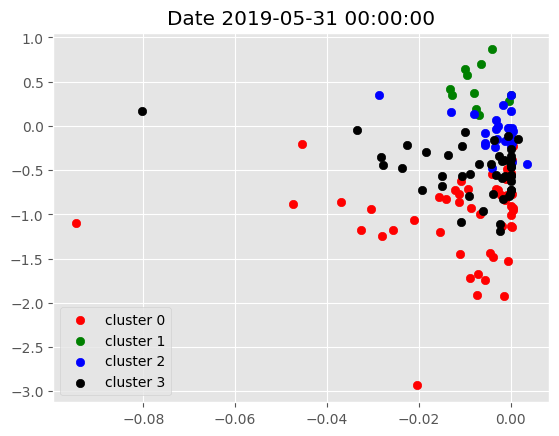

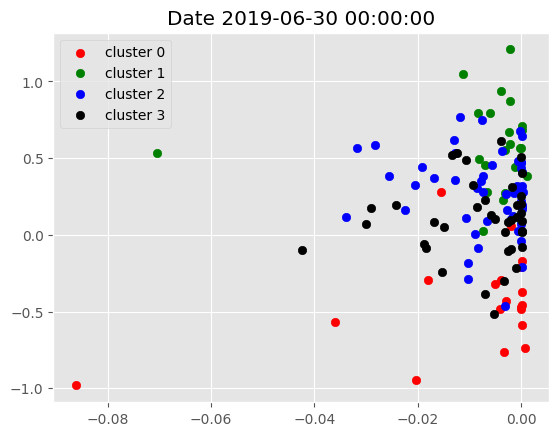

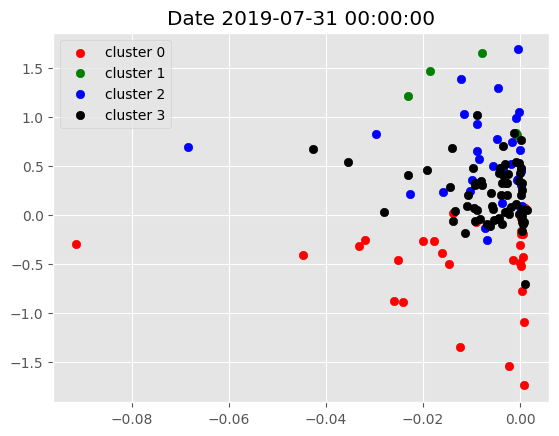

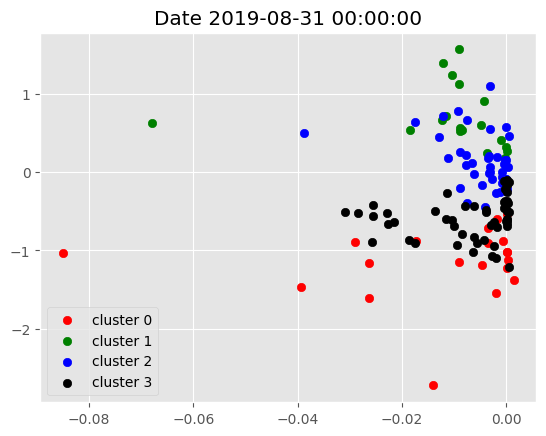

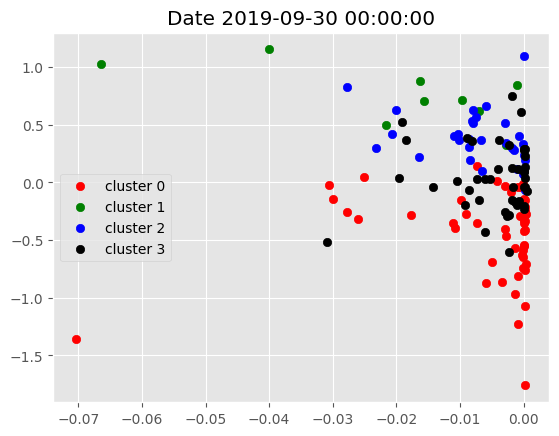

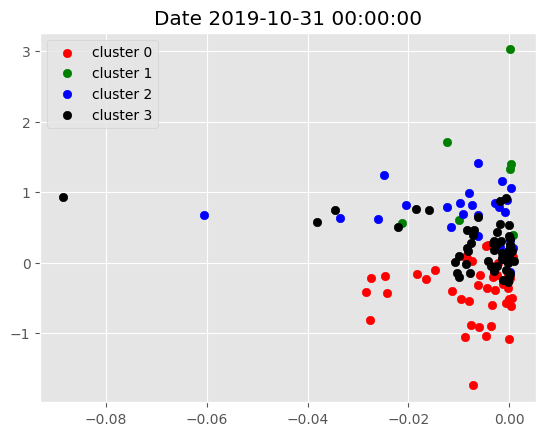

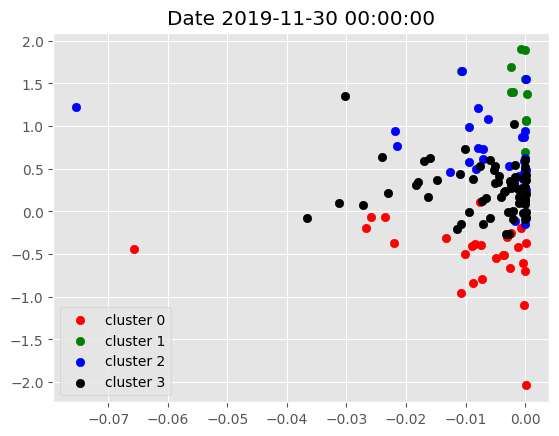

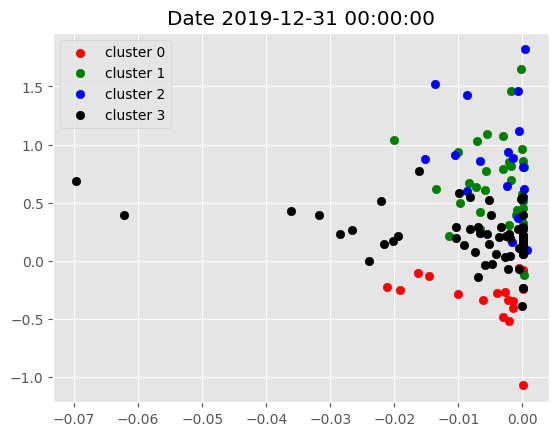

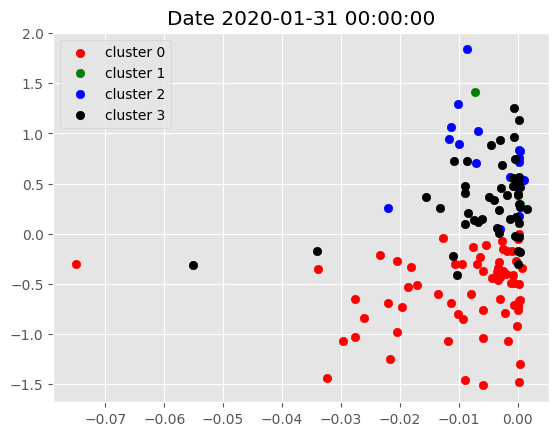

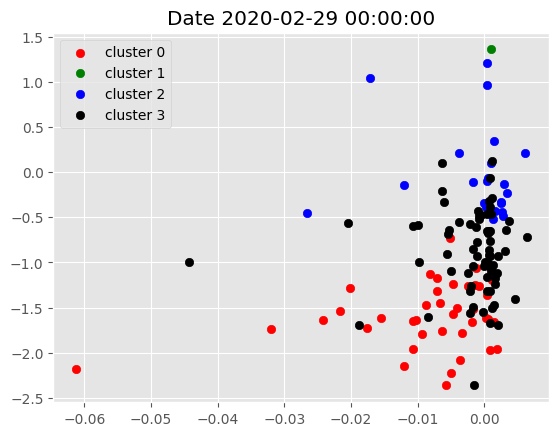

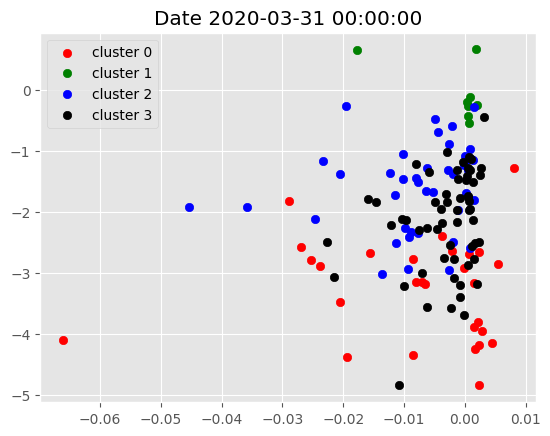

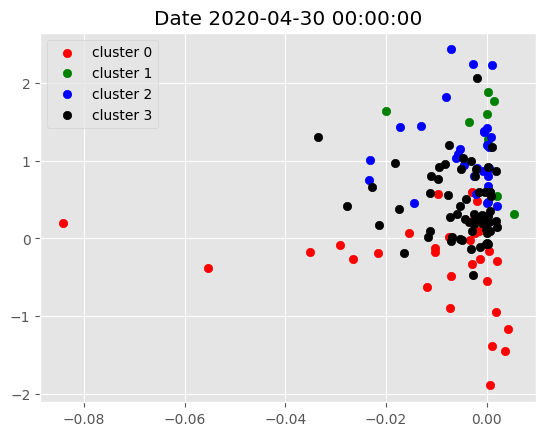

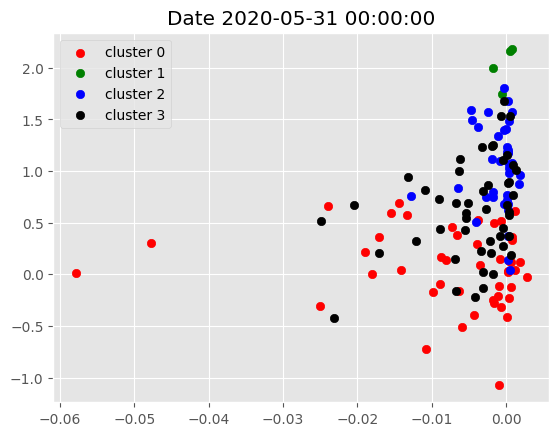

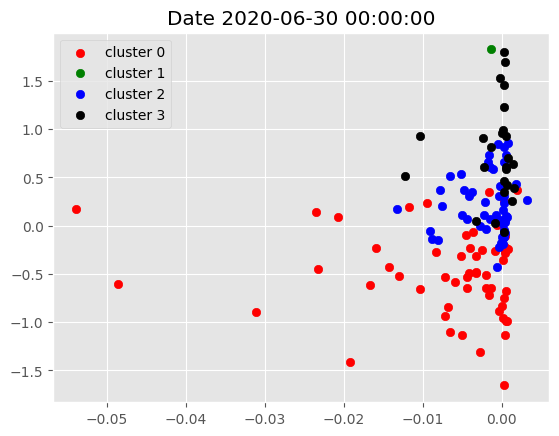

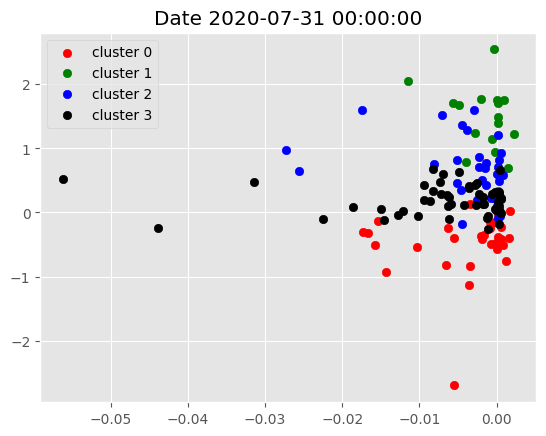

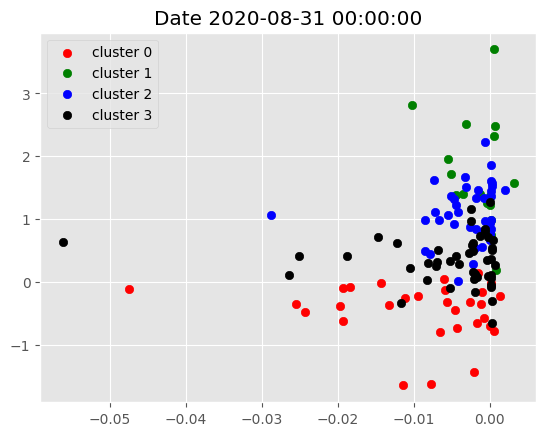

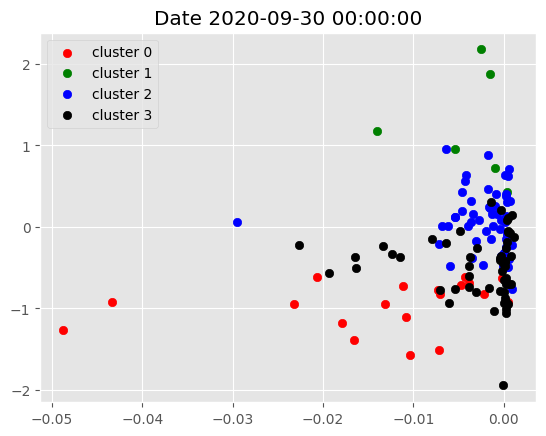

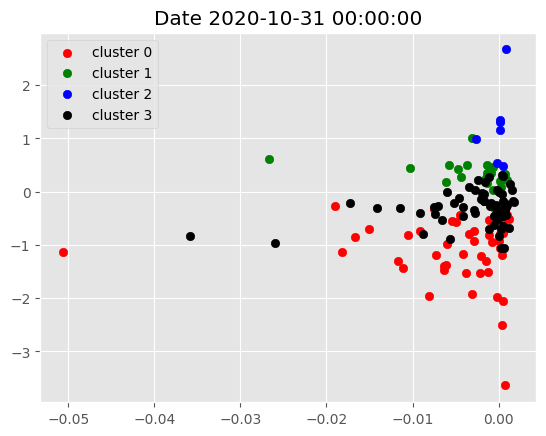

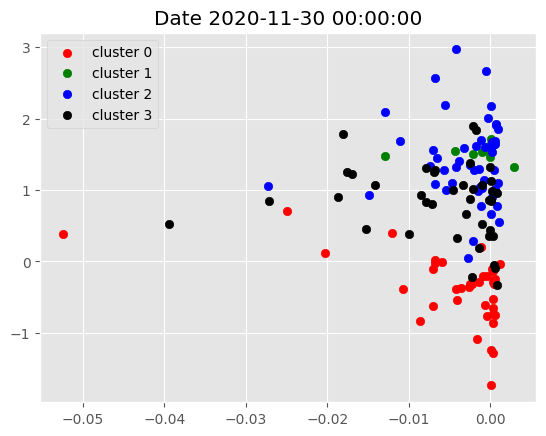

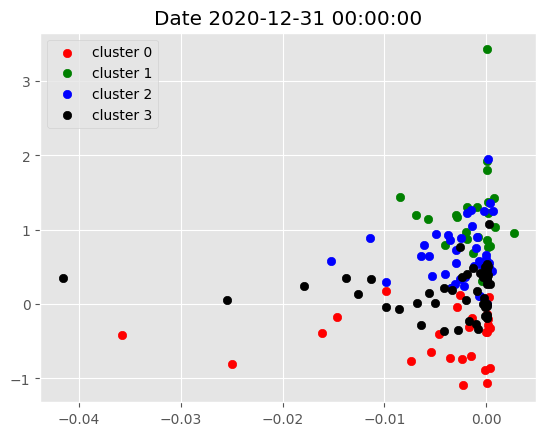

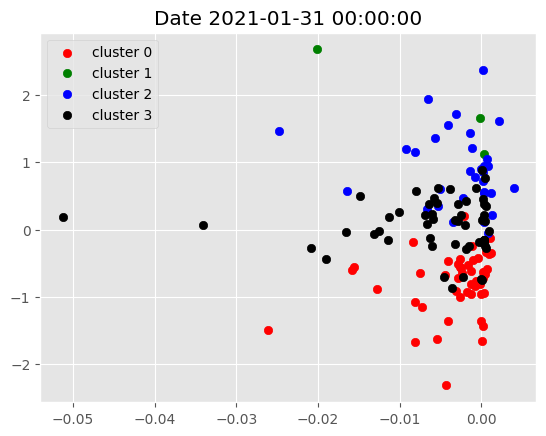

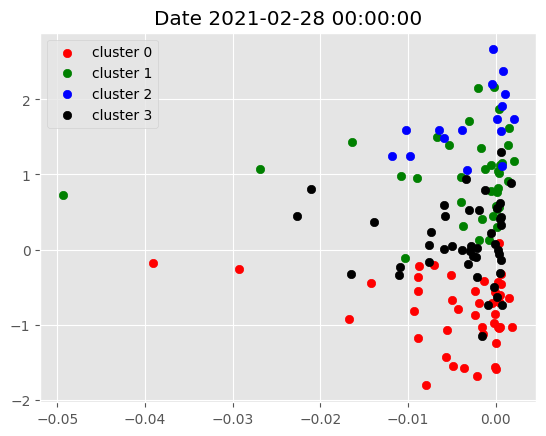

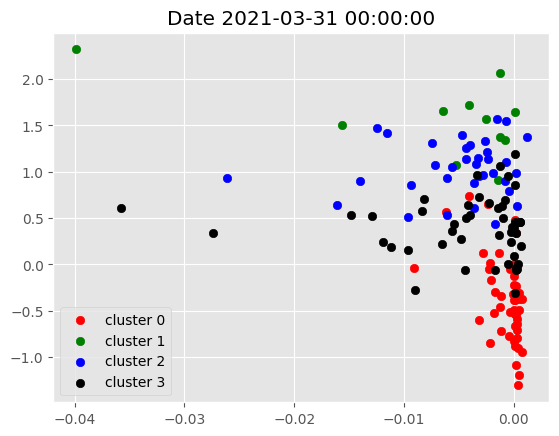

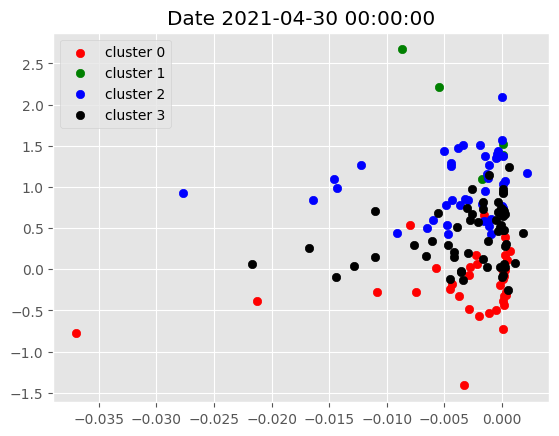

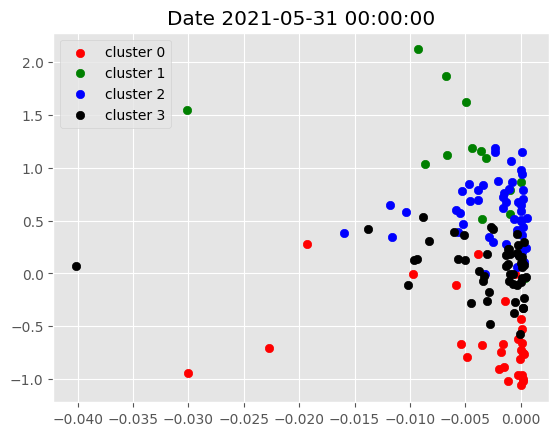

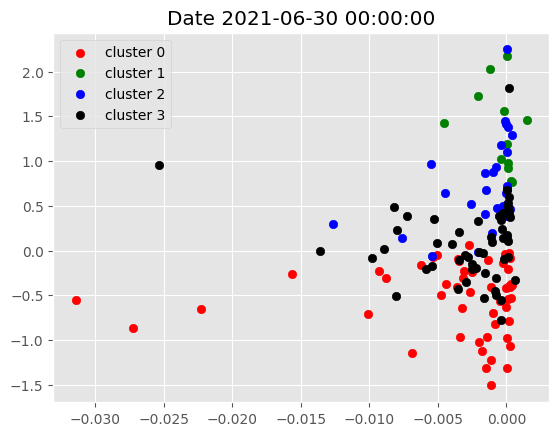

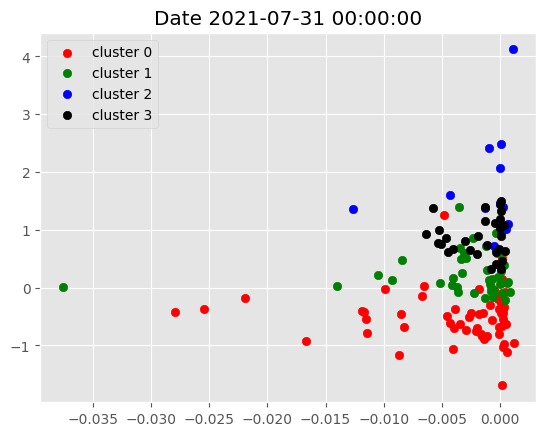

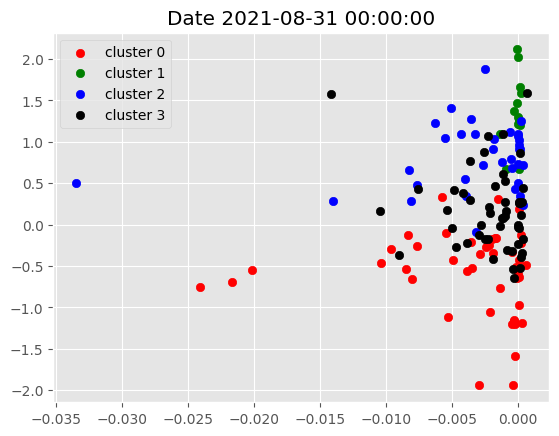

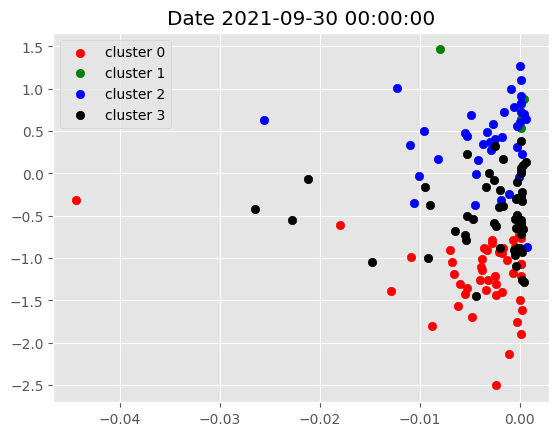

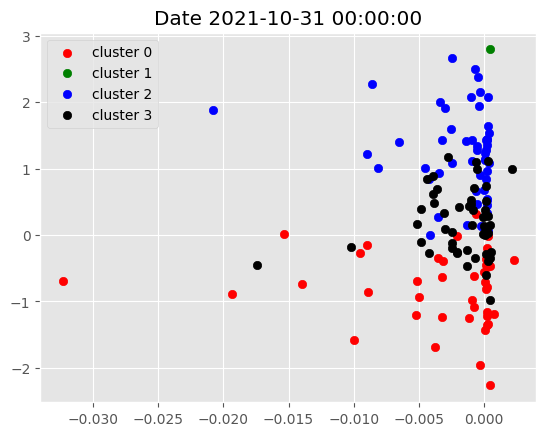

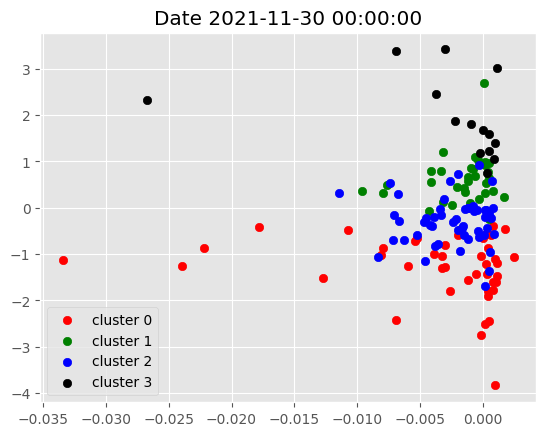

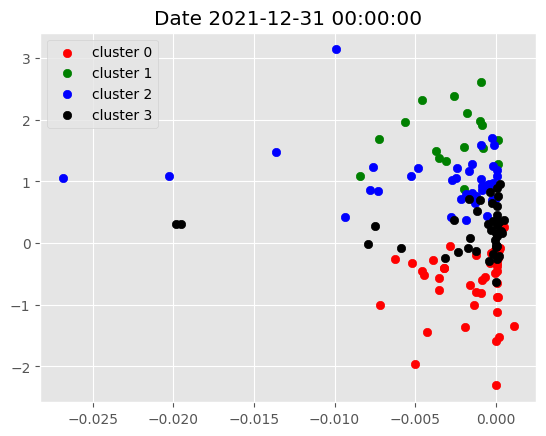

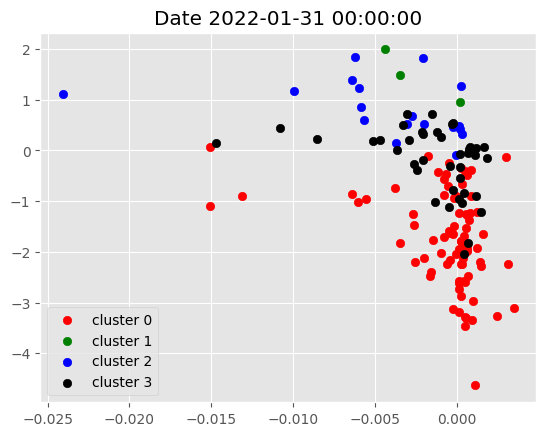

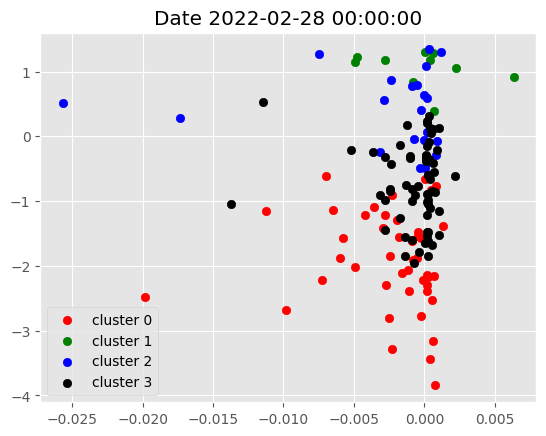

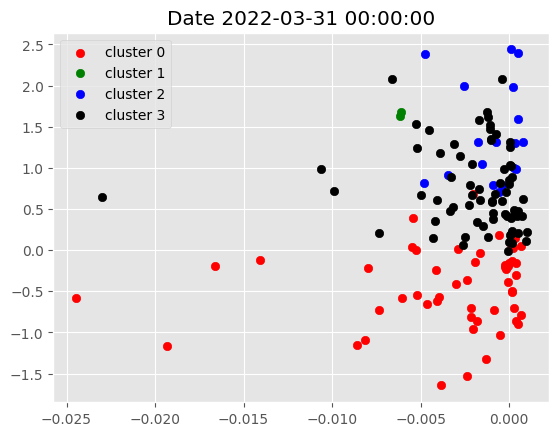

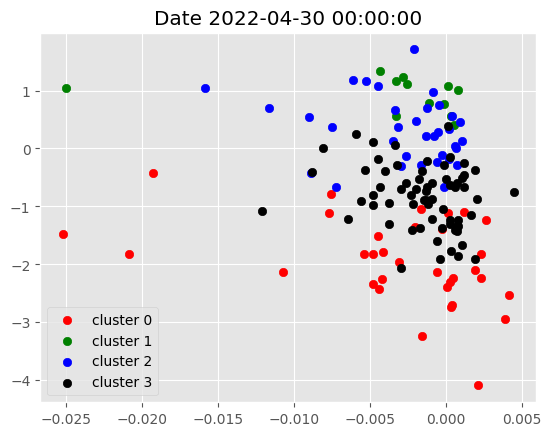

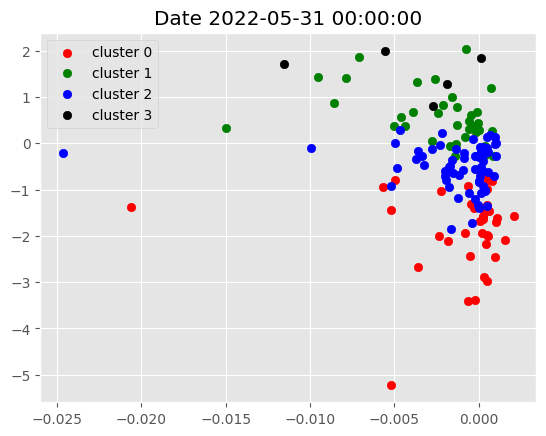

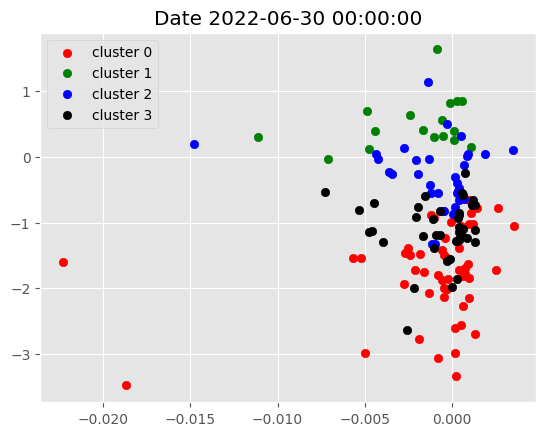

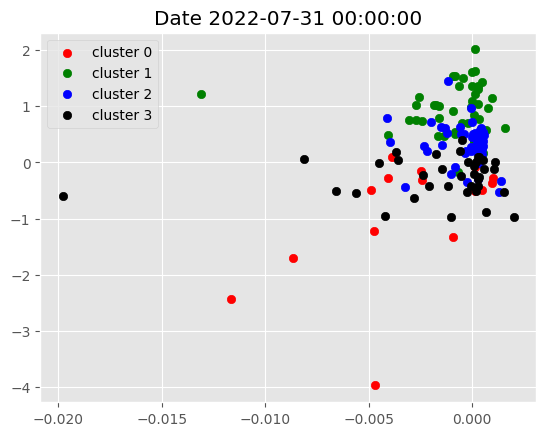

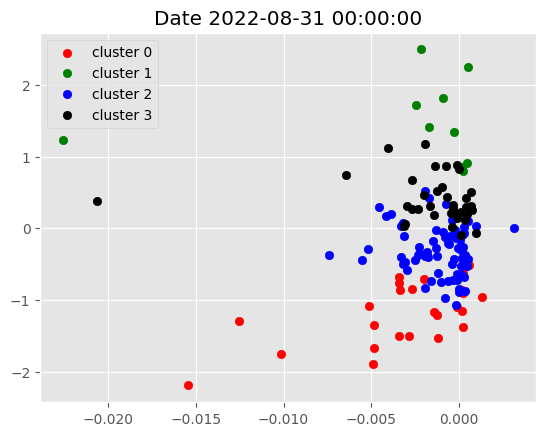

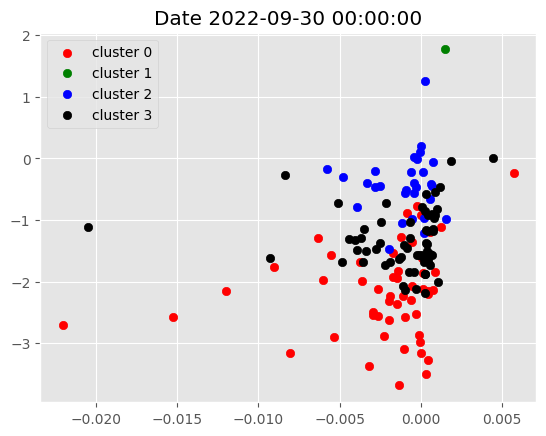

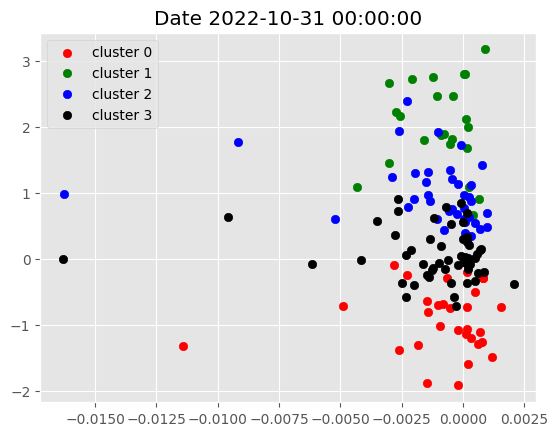

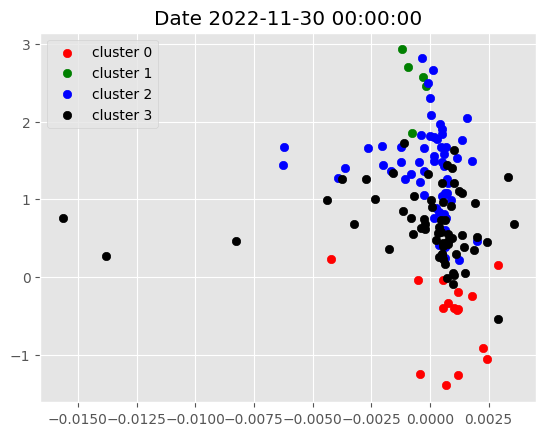

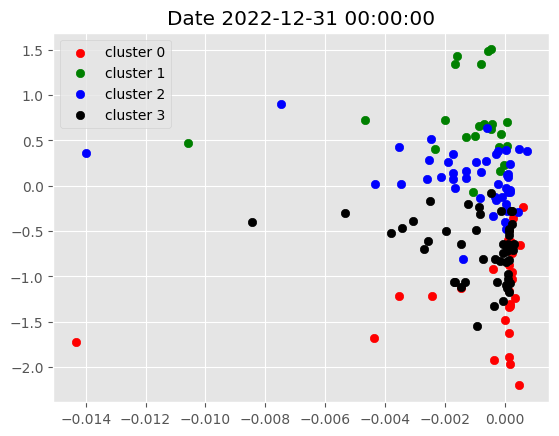

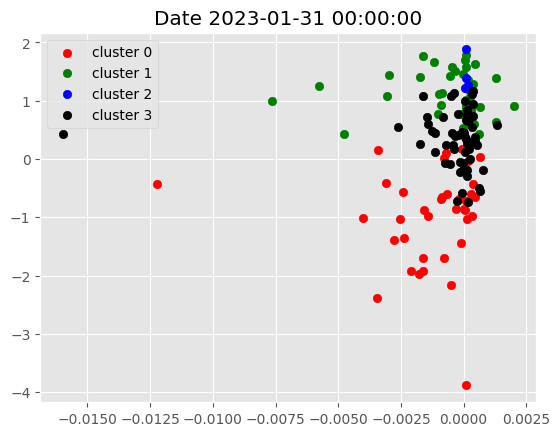

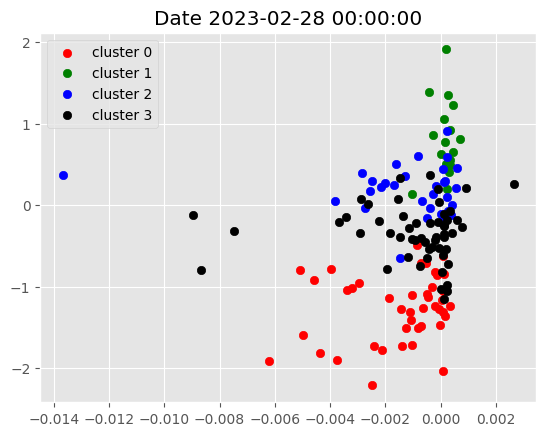

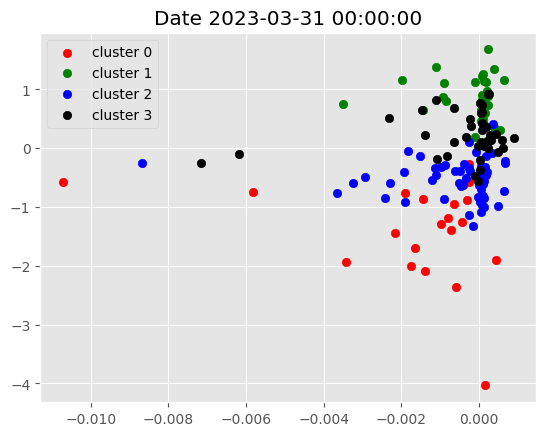

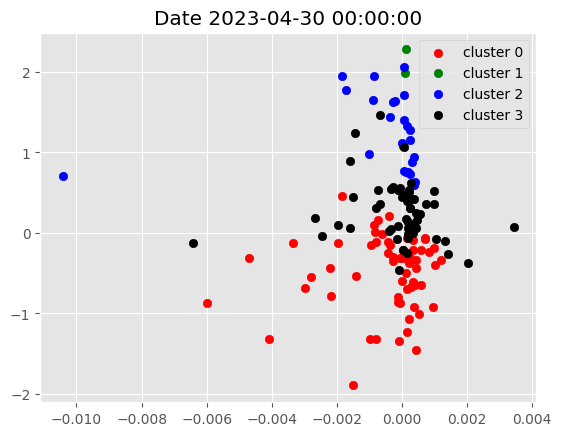

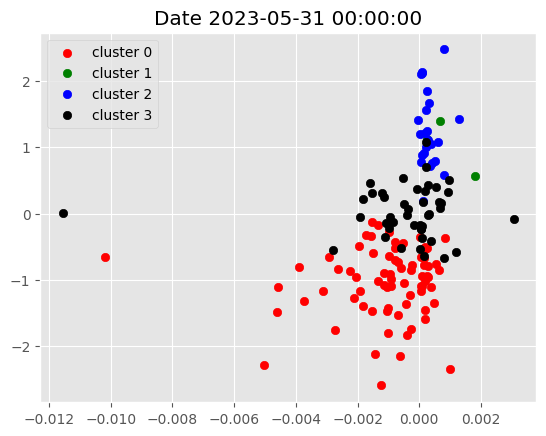

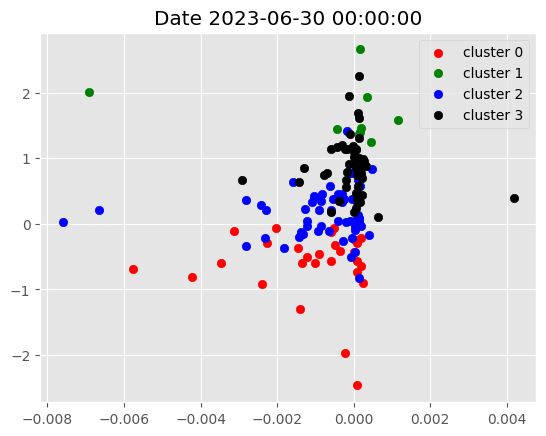

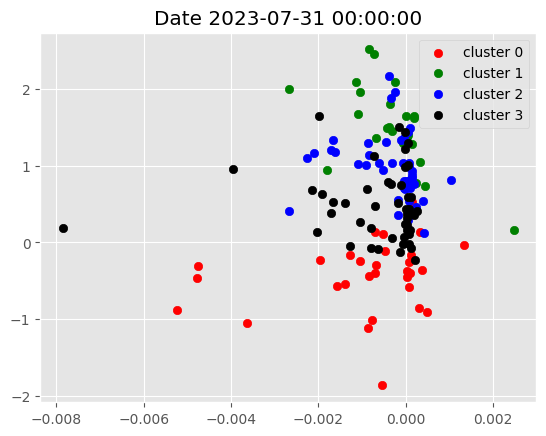

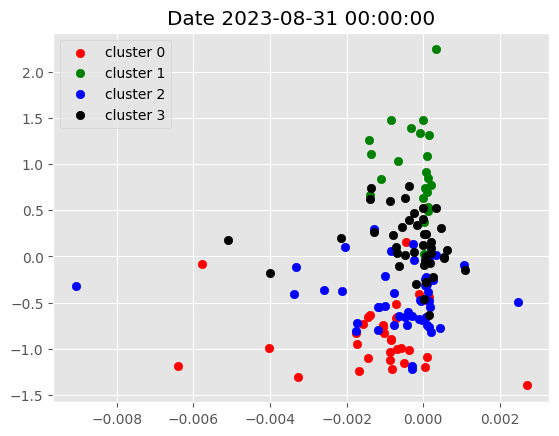

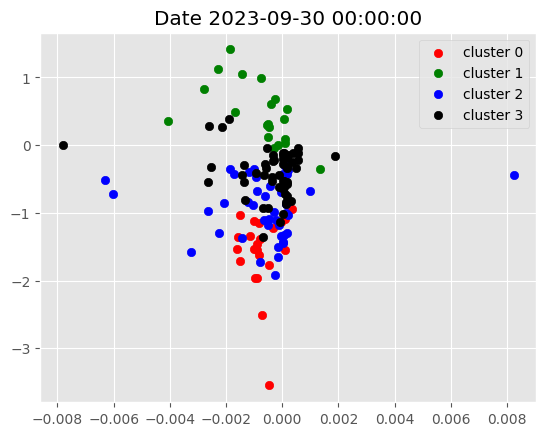

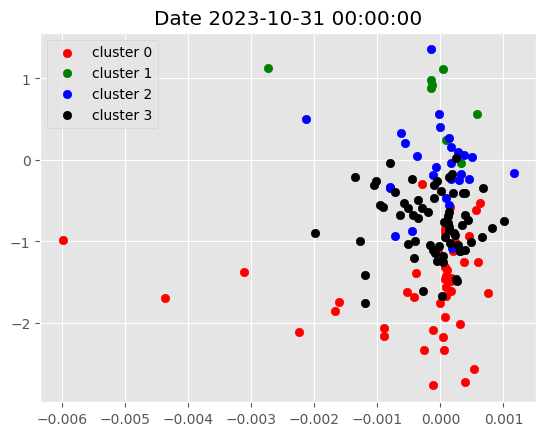

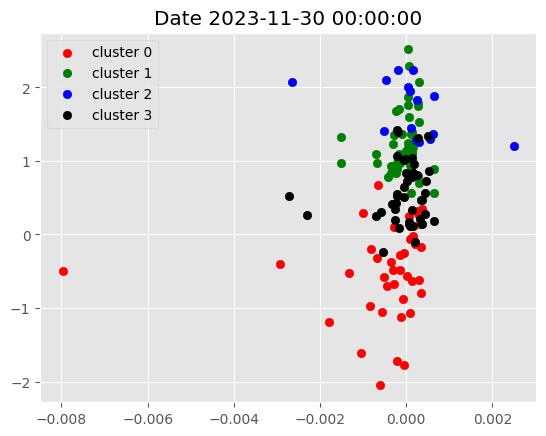

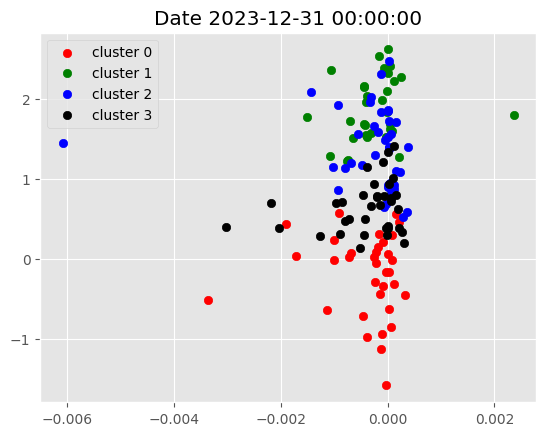

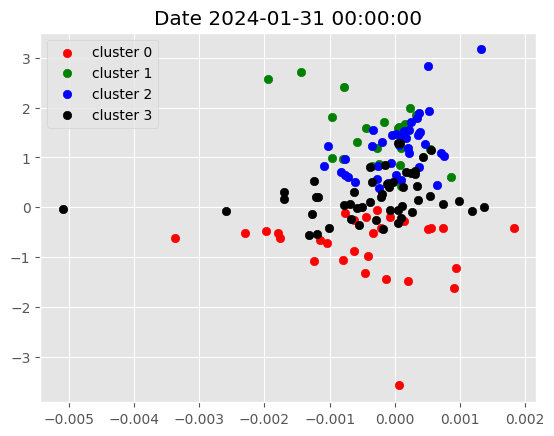

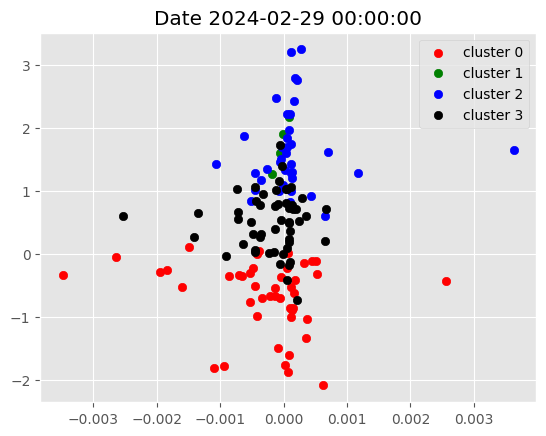

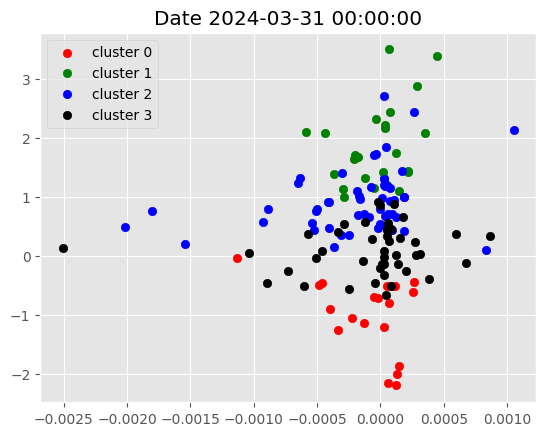

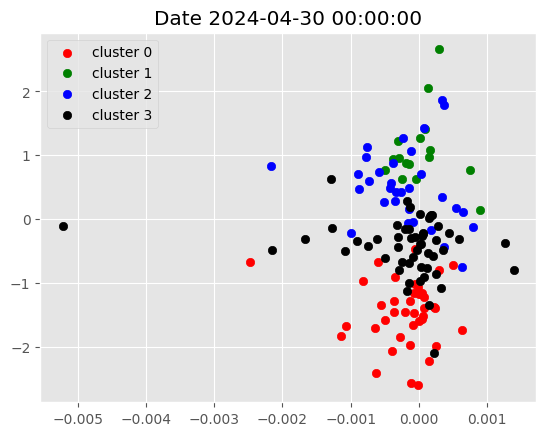

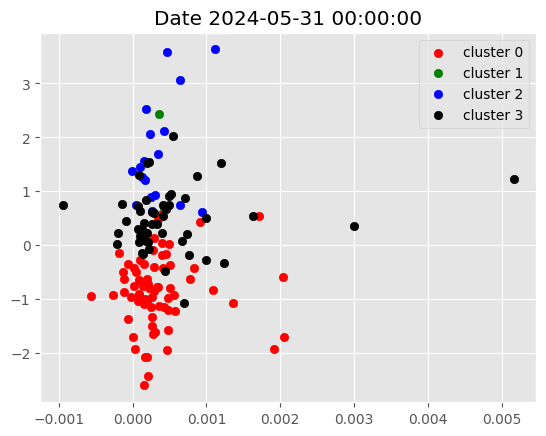

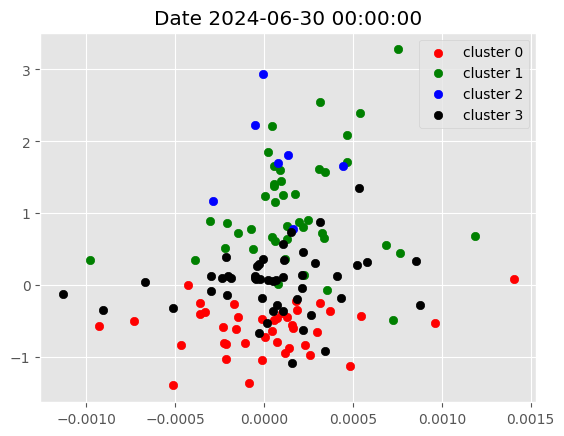

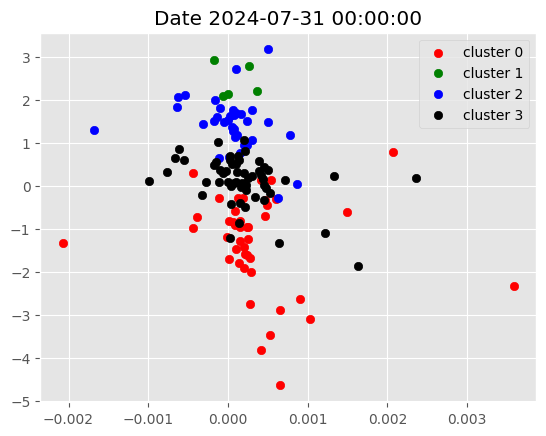

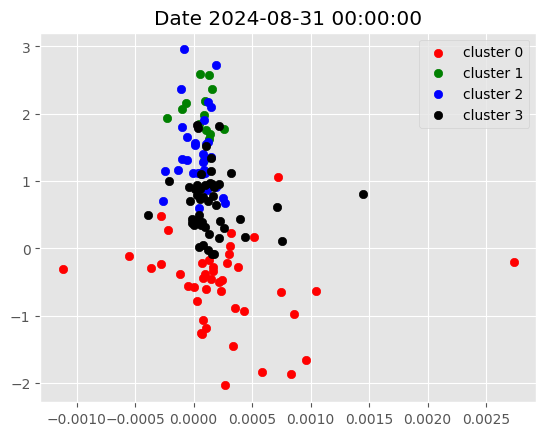

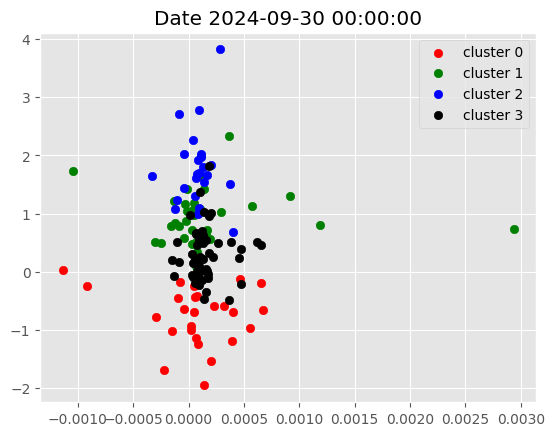

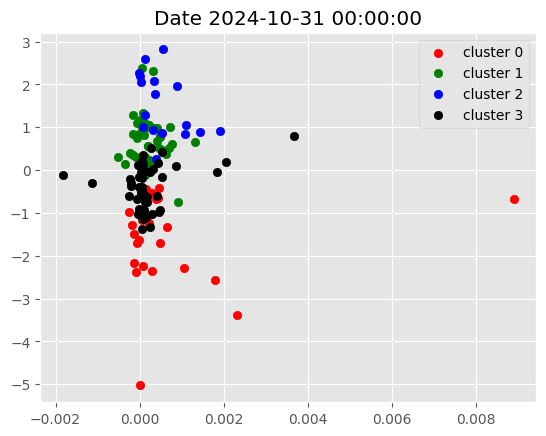

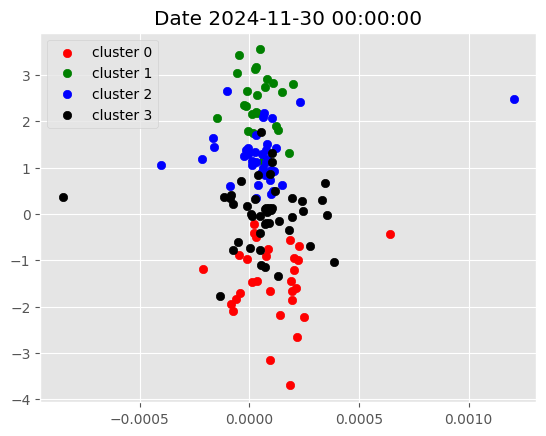

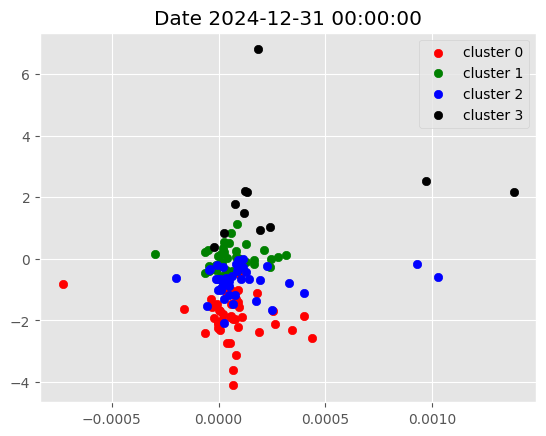

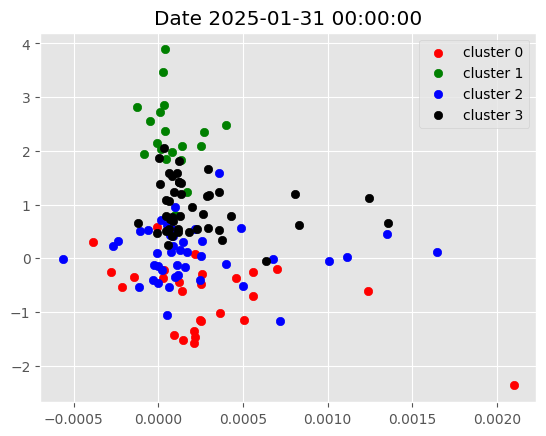

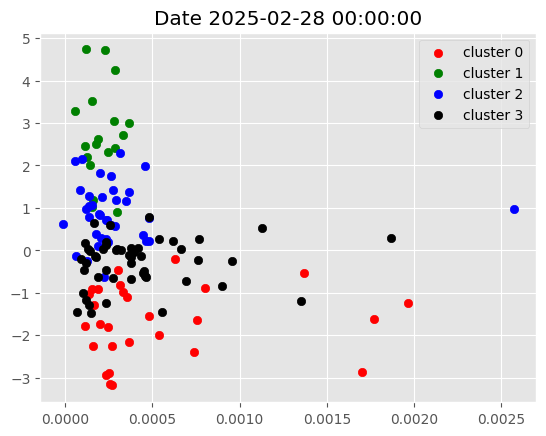

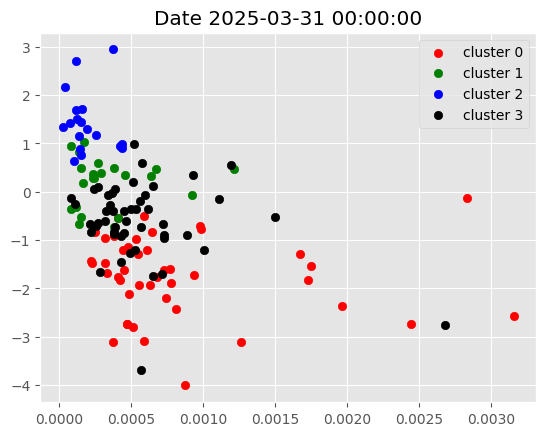

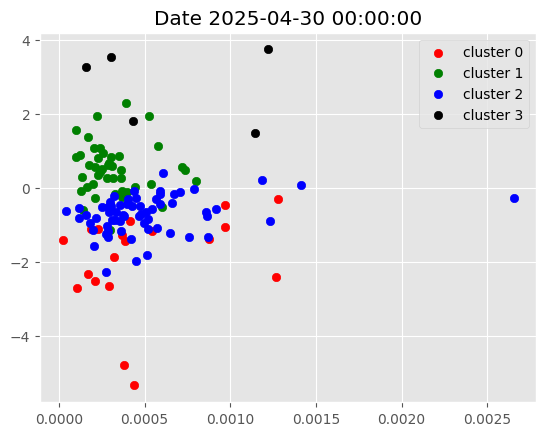

In [177]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [178]:
filtered_df = data[data['cluster']==3].copy()
filtered_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-05-31 ABBV           -0.028138  40.509229  4.087179  4.120630  4.154082   
           ADSK            0.000126  42.624169  5.075266  5.139509  5.203752   
           ALGN            0.001627  40.691122  5.679790  5.758807  5.837824   
           AMAT           -0.001524  41.300703  3.606718  3.670488  3.734258   
           AMZN            0.000055  40.977738  4.495004  4.545999  4.596993   
...                             ...        ...       ...       ...       ...   
2025-04-30 BKNG            0.001143  61.990270  8.333363  8.432650  8.531937   
           CRWD            0.000435  60.920783  5.762273  5.936423  6.110574   
           NFLX            0.000301  68.609313  6.714033  6.890636  7.067240   
           PLTR            0.001222  66.037816  4.293069  4.556777  4.820486   
           PM              0.000155  68.928533  4.992321  5.084391  5.176461   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-05-31 ABBV   -1.010110 -0.346709  -0.033757  -0.017923  -0.006405   
           ADSK   -0.626220 -0.560529  -0.097076   0.016202  -0.004313   
           ALGN   -0.131173 -0.150312  -0.124215   0.000035   0.031655   
           AMAT   -1.065803 -0.385641  -0.117589  -0.009782   0.004741   
           AMZN   -0.987561 -0.454203  -0.078613  -0.001596   0.026768   
...                     ...       ...        ...        ...        ...   
2025-04-30 BKNG    4.469513  1.497387   0.106876   0.009299   0.025528   
           CRWD    2.797926  1.802254   0.216376   0.049107   0.025153   
           NFLX    4.567903  3.550783   0.213602   0.074317   0.050309   
           PLTR    3.588156  3.751180   0.403318   0.180985   0.128147   
           PM      3.590481  3.272975   0.079569   0.055128   0.099103   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-05-31 ABBV    -0.029679  -0.020684   -0.017210  0.542049  0.139723   
           ADSK     0.018089   0.004635    0.018524  1.396493 -0.200168   
           ALGN     0.036069  -0.033525   -0.012815  0.782067  1.625908   
           AMAT     0.007919  -0.009980   -0.020743  1.414132  0.592685   
           AMZN     0.008202  -0.013863    0.007150  1.191483 -0.460089   
...                      ...        ...         ...       ...       ...   
2025-04-30 BKNG     0.015165   0.036510    0.033762  1.208081  0.026254   
           CRWD     0.063228   0.070673    0.032393  1.241060 -2.792858   
           NFLX     0.069547   0.067562    0.061873  1.450206 -0.874186   
           PLTR     0.190704   0.176673    0.150020 -0.251007  1.340418   
           PM       0.046989   0.048755    0.053072  0.529050 -0.232414   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-05-31 ABBV   -0.054981  0.270811  0.577820        3  
           ADSK    0.364529 -0.469490 -0.796677        3  
           ALGN   -0.176487  0.810696 -1.605455        3  
           AMAT    0.211638  0.319599 -0.512804        3  
           AMZN   -0.370396 -0.613744 -0.640477        3  
...                     ...       ...       ...      ...  
2025-04-30 BKNG   -0.193438 -0.002277  1.465058        3  
           CRWD    0.137621 -4.306280 -2.634703        3  
           NFLX   -0.129767 -0.541740 -1.591958        3  
           PLTR   -3.865396 -6.761454 -1.495567        3  
           PM      1.260213  0.340406  0.366205        3  

[3492 rows x 19 columns]

In [179]:
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)

In [180]:
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

In [181]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
fixed_dates

{'2019-06-01': ['ABBV',
  'ADSK',
  'ALGN',
  'AMAT',
  'AMZN',
  'BA',
  'BMY',
  'C',
  'CI',
  'CMCSA',
  'CMG',
  'COP',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'CVX',
  'DE',
  'EBAY',
  'EL',
  'F',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'HD',
  'HUM',
  'JPM',
  'LLY',
  'MAR',
  'META',
  'MGM',
  'NFLX',
  'NXPI',
  'PG',
  'QCOM',
  'RTX',
  'SCHW',
  'SHW',
  'T',
  'TJX',
  'TXN',
  'UNP',
  'USB',
  'VRTX'],
 '2019-07-01': ['ADP',
  'AMD',
  'AMT',
  'AMZN',
  'BA',
  'BIIB',
  'CI',
  'CMCSA',
  'COP',
  'CSX',
  'CVS',
  'DD',
  'ELV',
  'EOG',
  'IBM',
  'INTC',
  'JNJ',
  'LOW',
  'LRCX',
  'MMM',
  'MS',
  'NFLX',
  'NKE',
  'NOW',
  'NXPI',
  'PEP',
  'PG',
  'PYPL',
  'RTX',
  'SHW',
  'TJX',
  'TSLA',
  'ULTA',
  'UNH',
  'UNP',
  'UPS',
  'VZ',
  'WYNN',
  'XOM'],
 '2019-08-01': ['ACN',
  'ADBE',
  'ADP',
  'AVGO',
  'AXP',
  'AZO',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'C',
  'CAT',
  'CI',
  'CMCSA',
  'CRM',
  'CVS',
  'CVX',
  'DD',
  'DE',
  'DHR

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [182]:
!pip install PyPortfolioOpt

In [183]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [184]:
def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [185]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1],
                     auto_adjust=False,)   # <-- get raw prices + “Adj Close”

[*********************100%***********************]  154 of 154 completed


* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [186]:
new_df

Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-05-31   44.204166   72.653069         NaN   54.458668  140.315796   
2018-06-01   45.001347   71.999527         NaN   55.237541  143.153763   
2018-06-04   45.377476   72.770569         NaN   55.777431  143.640305   
2018-06-05   45.727558   72.873383         NaN   55.786289  144.081772   
2018-06-06   45.886047   73.416771         NaN   56.237671  146.595474   
...                ...         ...         ...         ...         ...   
2025-04-23  204.332062  177.050003  118.279999  129.839996  288.160004   
2025-04-24  208.097107  180.369995  121.709999  129.380005  291.410004   
2025-04-25  209.005920  186.059998  122.510002  128.850006  293.390015   
2025-04-28  209.864792  192.339996  123.300003  129.529999  293.250000   
2025-04-29  210.933395  193.509995  125.489998  130.500000  298.470001   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-05-31  249.279999   84.862663  112.242470  129.100006  331.950012  ...   
2018-06-01  251.309998   85.928024  114.581909  133.520004  333.089996  ...   
2018-06-04  253.339996   87.307770  115.894096  135.570007  343.200012  ...   
2018-06-05  252.699997   87.884132  115.738701  136.800003  346.079987  ...   
2018-06-06  253.949997   89.159058  117.491142  137.929993  346.369995  ...   
...                ...         ...         ...         ...         ...  ...   
2025-04-23  351.959991  182.280090  293.540009  264.440002  177.229996  ...   
2025-04-24  360.910004  194.345154  294.549988  271.709991  184.270004  ...   
2025-04-25  367.720001  193.708054  291.760010  269.929993  183.350006  ...   
2025-04-28  368.619995  192.841995  293.570007  271.470001  181.089996  ...   
2025-04-29  370.980011  191.796753  295.769989  272.890015  177.750000  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                           
2018-05-31  5480900  1649400  27288300   6508700  2806000  6477540  17515900   
2018-06-01  2941900  2176800   9967100   3225500  5722200  4959530  14100200   
2018-06-04  3792000  2661000   9012600   3564200  3012500  5607271  10593700   
2018-06-05  3392500  2957800  10378000   6999100  1776700  3772005  11883900   
2018-06-06  3554200  3087500  12924800   5455600  2365900  6355692  15848200   
...             ...      ...       ...       ...      ...      ...       ...   
2025-04-23  3652900  1247300  29402100   8541300  1655700  5526000  20678800   
2025-04-24  4783000  1369100  16597300   7736800  1685400  5943900  18420900   
2025-04-25  2865100  1561500  23361900   6369000  1103300  4158500  17775900   
2025-04-28  2601000  1503300  16188500   7737400   898500  5916400  16694100   
2025-04-29  1428500  1254900  14712800  14838700  1134900  6871700  24563600   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2018-05-31  34406100  2240500  15803100  
2018-06-01  15713700  3732500   9906100  
2018-06-04  32766000  5783500  10954700  
2018-06-05  24844200  7194500  12059300  
2018-06-06  22088400  5006900  11603300  
...              ...      ...       ...  
2025-04-23  18046900  2810500  14235700  
2025-04-24  13444500  1937000   9849600  
2025-04-25  15317200  1467700  11245800  
2025-04-28  12950000  1443300  13890900  
2025-04-29  12679000  1463600   9483100  

[1738 rows x 924 columns]

In [187]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['Date', 'Ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2025-05-01, Continuing with Equal-Weights
'return'


,Strategy Return
Date,
2019-06-03,-0.002827
2019-06-04,0.021420
2019-06-05,0.007153
2019-06-06,0.006029
2019-06-07,0.012762
...,...
2025-04-23,0.020486
2025-04-24,0.005968
2025-04-25,0.005101


In [188]:
portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1486 entries, 2019-06-03 to 2025-04-29
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Strategy Return  1486 non-null   float64
dtypes: float64(1)
memory usage: 23.2 KB


In [189]:
spy = yf.download(tickers='SPY',
                  start='2019-06-03',
                  end='2025-04-30',
                  auto_adjust=False,)   # <-- get raw prices + “Adj Close”)
spy

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2019-06-03,250.177658,274.570007,276.549988,273.089996,275.309998,96428000
2019-06-04,255.608093,280.529999,280.679993,276.619995,277.119995,77231900
2019-06-05,257.822327,282.959991,282.989990,280.320007,282.329987,71169700
2019-06-06,259.498901,284.799988,285.549988,282.570007,283.290009,69430400
2019-06-07,262.095673,287.649994,288.850006,285.739990,285.929993,74272200
...,...,...,...,...,...,...
2025-04-23,535.419983,535.419983,545.429993,533.880005,540.429993,90590700
2025-04-24,546.690002,546.690002,547.429993,535.450012,536.719971,64150400


In [190]:
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)
spy_ret

Price,SPY Buy&Hold
Ticker,SPY
Date,
2019-06-04,0.021474
2019-06-05,0.008625
2019-06-06,0.006482
2019-06-07,0.009957
2019-06-10,0.004579
...,...
2025-04-23,0.015377
2025-04-24,0.020830


In [191]:
spy_ret.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1485 entries, 2019-06-04 to 2025-04-29
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (SPY Buy&Hold, SPY)  1485 non-null   float64
dtypes: float64(1)
memory usage: 23.2 KB


In [192]:
spy_ret.columns = ['SPY Buy&Hold']

In [193]:
print(spy_ret.head())
spy_ret.info()

            SPY Buy&Hold
Date                    
2019-06-04      0.021474
2019-06-05      0.008625
2019-06-06      0.006482
2019-06-07      0.009957
2019-06-10      0.004579
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1485 entries, 2019-06-04 to 2025-04-29
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SPY Buy&Hold  1485 non-null   float64
dtypes: float64(1)
memory usage: 23.2 KB


In [194]:
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,Strategy Return,SPY Buy&Hold
Date,,
2019-06-04,0.021420,0.021474
2019-06-05,0.007153,0.008625
2019-06-06,0.006029,0.006482
2019-06-07,0.012762,0.009957
2019-06-10,0.000727,0.004579
...,...,...
2025-04-23,0.020486,0.015377
2025-04-24,0.005968,0.020830
2025-04-25,0.005101,0.007199


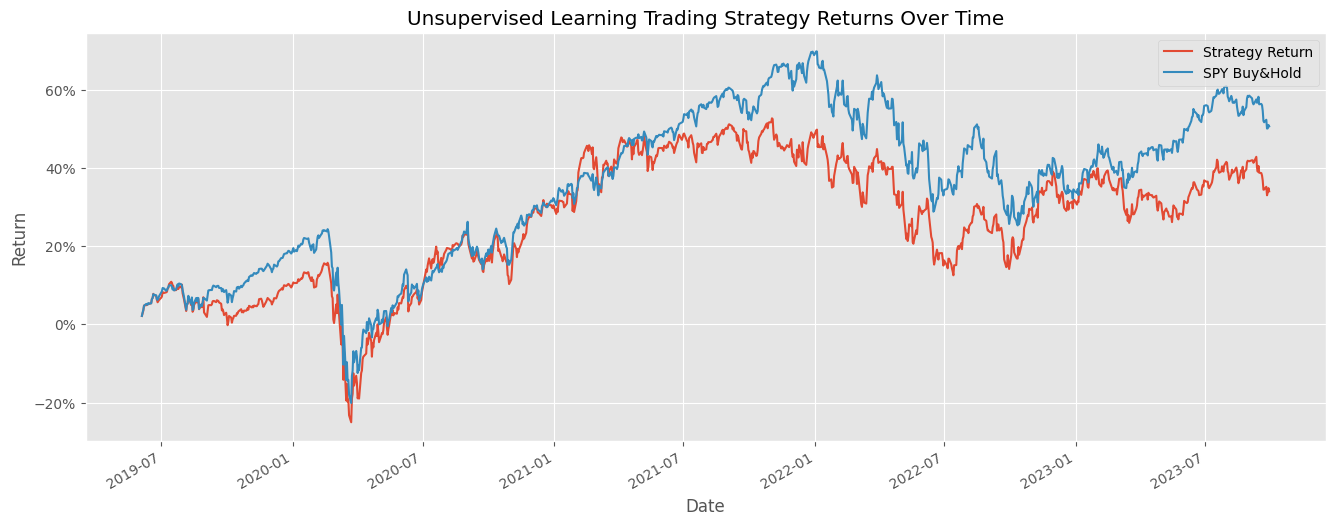

In [195]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()